# Galaxy Classification with CNN

Galaxies appear with different shapes and colors depending on a number of factors, including age, distance, and history of mergers with other galaxies. A crowd-sourced group was [asked to visually classify a set of galaxies from a telescope survey](https://data.galaxyzoo.org/gz_trees/gz_trees.html), resulting in a labelled dataset of 21,785 galaxies across 10 different labels.

Downloadable here:
```bash
curl -o galaxies10.h5 http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
```

The galaxies have all been assigned a label between 0-9 based on their shape:

```
Galaxy10 dataset (17736 images)
├── Class 0 (1081 images): Disturbed Galaxies
├── Class 1 (1853 images): Merging Galaxies
├── Class 2 (2645 images): Round Smooth Galaxies
├── Class 3 (2027 images): In-between Round Smooth Galaxies
├── Class 4 ( 334 images): Cigar Shaped Smooth Galaxies
├── Class 5 (2043 images): Barred Spiral Galaxies
├── Class 6 (1829 images): Unbarred Tight Spiral Galaxies
├── Class 7 (2628 images): Unbarred Loose Spiral Galaxies
├── Class 8 (1423 images): Edge-on Galaxies without Bulge
└── Class 9 (1873 images): Edge-on Galaxies with Bulge
```

### Load the data

In [1]:
import h5py
import numpy as np
from tensorflow.keras import utils

# To get the images and labels from file
with h5py.File('/Users/alizabeverage/Downloads/Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])
    labels_ = np.array(F['ans'])

# Convert the labels to categorical 10 classes
labels = utils.to_categorical(labels_, 10)

# Convert to desirable type
labels = labels.astype(np.float32)
images = images.astype(np.float32)

print(f"labels shape: {labels.shape}")
print(f"images shape: {images.shape}")

labels shape: (17736, 10)
images shape: (17736, 256, 256, 3)


### Visualize and inspect

Here, we visualize one randomly chosen galaxy from each othe 10 classes.

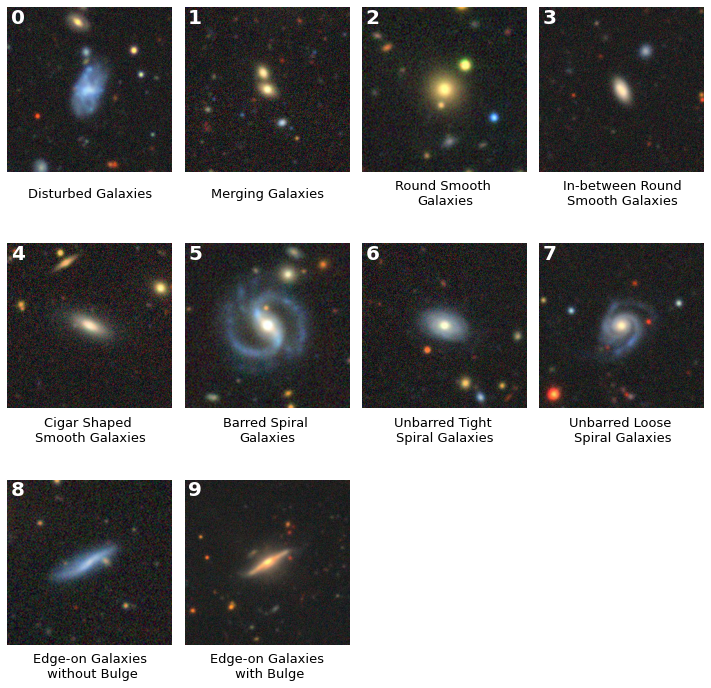

In [2]:
import matplotlib.pyplot as plt
np.random.seed(99)

fig, axs = plt.subplots(3, 4,figsize=(10,10))
axs = axs.ravel()

[ax.set_axis_off() for ax in axs]

description = ['Disturbed Galaxies','Merging Galaxies','Round Smooth \nGalaxies','In-between Round\nSmooth Galaxies',
'Cigar Shaped \nSmooth Galaxies','Barred Spiral \nGalaxies','Unbarred Tight \nSpiral Galaxies',
'Unbarred Loose \nSpiral Galaxies','Edge-on Galaxies\n without Bulge','Edge-on Galaxies\n with Bulge']

for i,x in enumerate(np.random.rand(10)):
    ims_i = images[labels[:,i]==1] # select images of given label
    arg = int(x*len(ims_i)) #take random index
    axs[i].imshow(ims_i[arg,:,:,:]/np.max(ims_i[arg,:,:,:]),origin='lower')
    
    axs[i].text(5,230,i,c='white',weight='bold',fontsize=20)
    axs[i].axis('off')
    axs[i].text(128,-35,description[i],fontsize = 13,horizontalalignment='center',verticalalignment='center')
    
plt.tight_layout()

### Quickly check the distribution of galaxies across the classes

Here we notice that there are very few galaxies in class 4. Thus, the CNN will likely have a hard time accurately classifying the "cigar-shaped" galaxies.

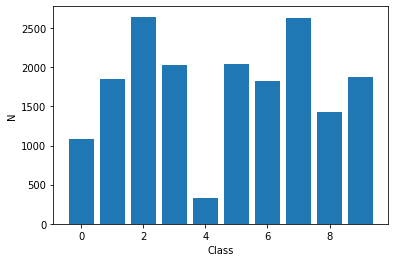

In [3]:
plt.bar(np.arange(10), np.sum(labels,axis=0))
plt.xlabel('Class')
plt.ylabel('N')
plt.show()

### Data augmentation

The images in the dataset are large comapred to the sizes of the primary galaxies (located in the center). Since most of the space in the images is not useful, we crop the images down to a much smaller size. This has two desired effects: (1) the CNN training will be pirmarily based on the central galaxy and (2) the training will require much less memory. To further reduce the required memory, I smooth the images to half the resolution. This decreased resolution is about as low as you'd want without smoothing out small but often constrianing features (like small star-forming knots).

The data augmentation steps are summarized as follows:
- Crop images, most galaxies are only at very center
- Decrease resolution
- Re-scale images to values between [0,1]

In [5]:
# Crop image, shrink from (256,256) to (128,128)
images_crop = images[:,64:192,64:192,:]

# resample image to lower resolution, (64,64)
small_images = images_crop.reshape((len(images_crop), 64, 128 // 64, 
                                   64, 128 //64, 3)).max(4).max(2)

# rescale images to values between [0,1]
normalizing_factor = small_images.reshape(small_images.shape[0],np.prod(small_images.shape[1:])).max(1)
images_rescaled = np.array([im/normalizing_factor[i] for i,im in enumerate(small_images)])

### Check augmented data

Before moving on to the training I check the same images as shown in teh grid above to ensure the augmented data still accurately represent the original images (without too much loss of information)

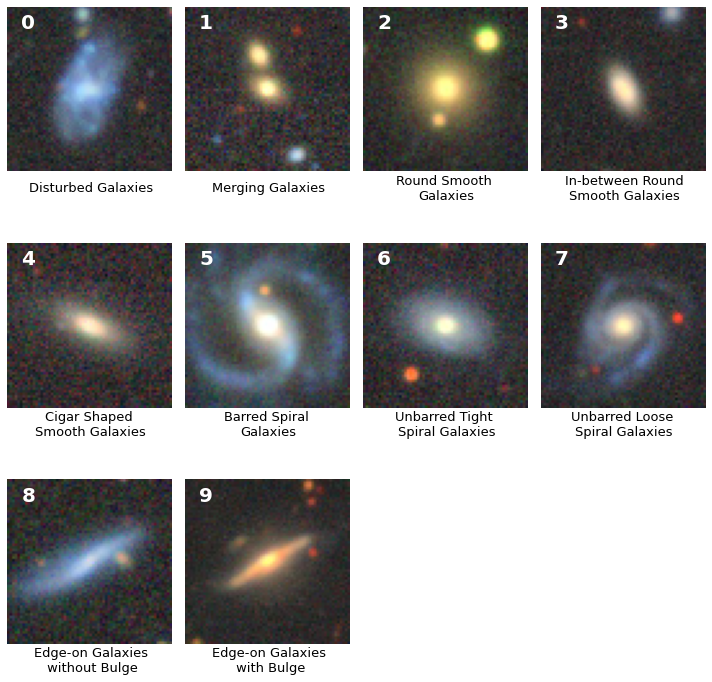

In [6]:
np.random.seed(99)

fig, axs = plt.subplots(3, 4,figsize=(10,10))
axs = axs.ravel()

[ax.set_axis_off() for ax in axs]

for i,x in enumerate(np.random.rand(10)):
    ims_i = images_rescaled[labels[:,i]==1] # select images of given label
    arg = int(x*len(ims_i)) #take random index
    axs[i].imshow(ims_i[arg,:,:,:],origin='lower')
    
    axs[i].text(5,55,i,c='white',weight='bold',fontsize=20)
    axs[i].axis('off')
    axs[i].text(32,-7,description[i],fontsize = 13,horizontalalignment='center',verticalalignment='center')
    
plt.tight_layout()

### Prepare for training

With the data augmentation complete, it's time to train the neural net. The first step is to split the dataset into a train, validation, and test set with a fixed random seed. 

In [7]:
import datetime, os
import numpy as np
import warnings

# from IPython.external import mathjax

import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Activation, BatchNormalization
)
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
# Print keras version
print("Using tensorflow version:", tensorflow.keras.__version__)

Using tensorflow version: 2.8.0


In [8]:
from sklearn.model_selection import train_test_split

rnd = np.random.RandomState(41)

# make an array with the indices of all the rows in the dataset
ind_arr = np.arange(images_rescaled.shape[0])
rnd.shuffle(ind_arr)


train_percentage, valid_percentage, test_percentage = (0.90, 0.05, 0.05)
train_ind, tmp = train_test_split(ind_arr, train_size=train_percentage, random_state=rnd)
valid_ind, test_ind = \
      train_test_split(tmp, train_size=valid_percentage/(valid_percentage + test_percentage), 
                               random_state=rnd)

train_y = labels[train_ind] ; test_y = labels[test_ind] ; valid_y = labels[valid_ind]

In [9]:
assert np.all(np.array(sorted(list(train_ind) + list(valid_ind) + list(test_ind)))  == \
              sorted(ind_arr))

In [10]:
# check sizes of the three datasets
train_ind.shape, test_ind.shape, valid_ind.shape

((15962,), (887,), (887,))

In [68]:
# separate the data into the three datasets

train_X = images_rescaled[train_ind]
test_X = images_rescaled[test_ind]
valid_X = images_rescaled[valid_ind]

train_y = labels[train_ind] ; test_y = labels[test_ind] ; valid_y = labels[valid_ind]

# make sure the sizes of the label arrays match the sizes of the datasets
assert train_y.shape[0] == train_X.shape[0]
assert test_y.shape[0] == test_X.shape[0]
assert valid_y.shape[0] == valid_X.shape[0]

### Train the CNN

Finally, I construct a simple CNN that accommodates the images and returns a classification. The network itself has five hidden layers -- three convolutional layers, followed by two fully-connected layers. A RELU activation function is used after each layer, and a max-pooling layer is used after each of the convolutional layers. I use a dropout layer after the final max pooling to avoid overfitting.  

In [79]:
input_shape = train_X[0].shape
with tf.device('/gpu:0'): # uses GPU
    model = Sequential()
    model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(64,64,3)))
    model.add(MaxPooling2D())

    model.add(Conv2D(64, 3, padding="same", activation="relu"))
    model.add(MaxPooling2D())

    model.add(Conv2D(128, 3, padding="same", activation="relu"))
    model.add(MaxPooling2D())
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(128,activation="relu"))
    model.add(Dense(10, activation="softmax"))

model.summary()



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_296 (Conv2D)         (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_297 (Conv2D)         (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_298 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 8, 8, 128)       

### Compile model

I compile the model using the Adam optimizer and CategoricalCrossentropy as the loss function.

In [81]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])



### Train

Using early stopping and learning rate decay, train the network, use the validation dataset at the end of each epoch for the early stopping.

In [82]:
batch_size = 64

run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')
# define path to save model
model_path = f'nn_results/ay250_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")

logdir = os.path.join("nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,
                              patience=2, min_lr=1e-6, verbose=1, cooldown=0)

csv_logger = tf.keras.callbacks.CSVLogger(f'nn_results/training_{run_time_string}.log')

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, 
                                             patience=3, \
                                             verbose=1, mode='auto')

model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max',
        verbose=1)

model.fit(x=train_X, 
          y=train_y, 
          epochs=20,
          batch_size=batch_size,
          validation_data=(test_X, test_y), 
          callbacks=[reduce_lr, csv_logger, earlystop, model_check])

Training ... nn_results/ay250_nn_2022-12-13T00:13.h5
Epoch 1/20
250/250 [==============================] - ETA: 0s - loss: 1.7515 - accuracy: 0.3463
Epoch 1: val_accuracy improved from -inf to 0.47576, saving model to nn_results/ay250_nn_2022-12-13T00:13.h5
250/250 [==============================] - 8s 21ms/step - loss: 1.7515 - accuracy: 0.3463 - val_loss: 1.4112 - val_accuracy: 0.4758 - lr: 0.0010
Epoch 2/20
250/250 [==============================] - ETA: 0s - loss: 1.3354 - accuracy: 0.5091
Epoch 2: val_accuracy improved from 0.47576 to 0.53664, saving model to nn_results/ay250_nn_2022-12-13T00:13.h5
250/250 [==============================] - 5s 20ms/step - loss: 1.3354 - accuracy: 0.5091 - val_loss: 1.2524 - val_accuracy: 0.5366 - lr: 0.0010
Epoch 3/20
248/250 [============================>.] - ETA: 0s - loss: 1.1717 - accuracy: 0.5840
Epoch 3: val_accuracy improved from 0.53664 to 0.60879, saving model to nn_results/ay250_nn_2022-12-13T00:13.h5
250/250 [===========================

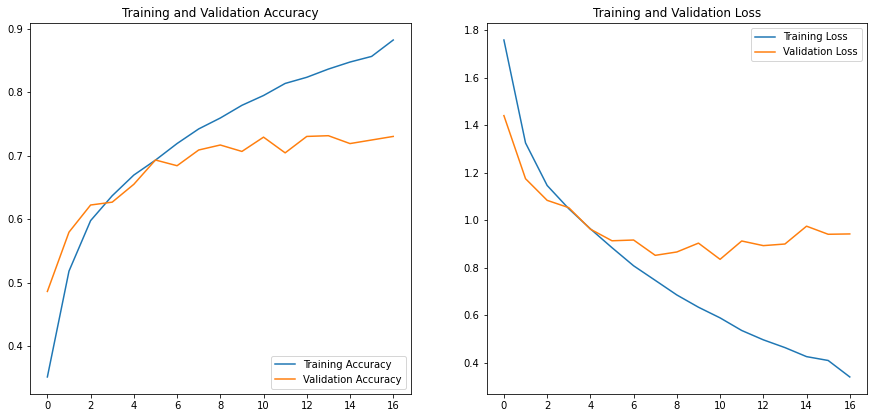

In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(17)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

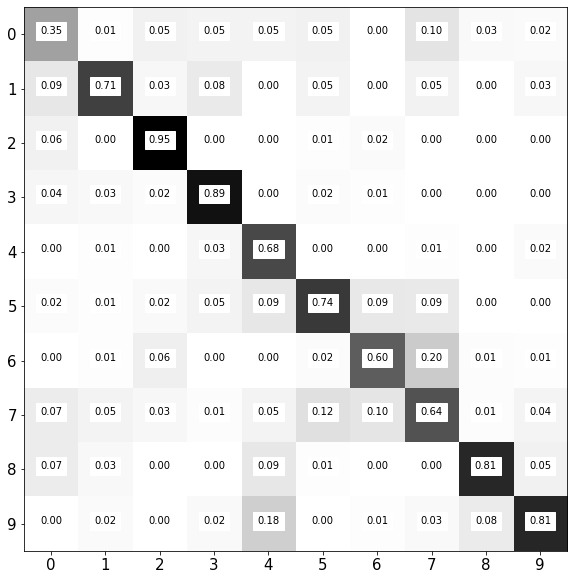

In [88]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_y, pred_y):
    C = confusion_matrix(np.argmax(test_y,axis=1), np.argmax(pred_y,axis=1))
    plt.figure(figsize=(10,10))
    Cnorm = C / C.astype(np.float).sum(axis=1)
    plt.imshow(Cnorm,cmap='gray_r')
    X,Y = np.meshgrid(np.arange(10),np.arange(10))

    plt.xticks(np.arange(10),fontsize=15)
    plt.yticks(np.arange(10),fontsize=15)
    [plt.text(X.ravel()[i],Y.ravel()[i],f'{Cnorm.ravel()[i]:0.2f}', horizontalalignment='center', backgroundcolor='white') \
     for i in range(len(Cnorm.ravel()))];
    
pred_y = model.predict(test_X.reshape(-1, 64, 64, 3, 1))
plot_confusion_matrix(test_y, pred_y)

In [89]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# creating the data aumentation genreators for both the training images and the training label masks
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=15.,
                     rescale=1.0,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode = 'nearest')

image_datagen = ImageDataGenerator(**data_gen_args)

seed = 42
batch_size = 1024

input_shape = train_X[0].shape

image_generator = image_datagen.flow(
    train_X,  train_y,
    shuffle = True,
    batch_size=batch_size,
    seed=seed)